#<font size="1000"><center>**TRABAJO PRACTICO N°4**</center></font>



In [101]:

options(repr.frame.max.cols = 400, repr.frame.max.rows = 50)

options(max.print = 350)
options(scipen = 7)
options(repr.plot.width = 10, repr.plot.height = 10)


#1 Dependencias

In [102]:
dependencies <- c("caret",
                "Boruta",
                "dplyr",
                "ggplot2",
                "randomForest",
                "adabag",
                "downloader",
                "audio",
                "rpart",
                "pROC",
                "crayon",
                "nnet",
                "mvoutlier")


In [103]:
if (length(dependencies) > 0)
{
    for (i in dependencies)
    {
        if (!requireNamespace(i, character.only = TRUE))
        {
            install.packages(i)
            if(requireNamespace(i,character.only = TRUE))
            {
                cat("se instalo " , i , "correctamente\n")
            }
        }
        else
        {
            cat("el paquete" , i , "ya estaba instalado\n")
        }
        library(i,character.only = TRUE)

    }
}
if(i == dependencies[length(dependencies)])
{
    print("se instaló y cargó todo correctamente")
}

el paquete caret ya estaba instalado
el paquete Boruta ya estaba instalado
el paquete dplyr ya estaba instalado
el paquete ggplot2 ya estaba instalado
el paquete randomForest ya estaba instalado
el paquete adabag ya estaba instalado
el paquete downloader ya estaba instalado
el paquete audio ya estaba instalado
el paquete rpart ya estaba instalado
el paquete pROC ya estaba instalado
el paquete crayon ya estaba instalado
el paquete nnet ya estaba instalado
el paquete mvoutlier ya estaba instalado
[1] "se instaló y cargó todo correctamente"


#2 Descargar archivo

In [104]:
#descargar datos
origin <- "https://archive.ics.uci.edu/static/public/697/predict+students+dropout+and+academic+success.zip"

download.file(origin, destfile = "origin.zip", mode = "wb")


file_list <- unzip("origin.zip", list = TRUE)
file_list


Name,Length,Date
<chr>,<dbl>,<dttm>
data.csv,533230,2023-05-23 09:50:00


In [105]:
if ("data.csv" %in% file_list["Name"])
{
    data <- read.csv(unz("origin.zip","data.csv"),sep = ";")
}
if(class(data) == "data.frame")
{
    print("se descargo el dataset correctamente")
}

[1] "se descargo el dataset correctamente"


In [106]:
variables <- data.frame(names(data)[1:5],
    names(data)[6:10],
    names(data)[11:15],
    names(data)[16:20],
    names(data)[21:25],
    names(data)[26:30],
    names(data)[31:35])
variables

names.data..1.5.,names.data..6.10.,names.data..11.15.,names.data..16.20.,names.data..21.25.,names.data..26.30.,names.data..31.35.
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Marital.status,Previous.qualification,Mother.s.occupation,Debtor,International,Curricular.units.1st.sem..grade.,Curricular.units.2nd.sem..approved.
Application.mode,Previous.qualification..grade.,Father.s.occupation,Tuition.fees.up.to.date,Curricular.units.1st.sem..credited.,Curricular.units.1st.sem..without.evaluations.,Curricular.units.2nd.sem..grade.
Application.order,Nacionality,Admission.grade,Gender,Curricular.units.1st.sem..enrolled.,Curricular.units.2nd.sem..credited.,Curricular.units.2nd.sem..without.evaluations.
Course,Mother.s.qualification,Displaced,Scholarship.holder,Curricular.units.1st.sem..evaluations.,Curricular.units.2nd.sem..enrolled.,Unemployment.rate
Daytime.evening.attendance.,Father.s.qualification,Educational.special.needs,Age.at.enrollment,Curricular.units.1st.sem..approved.,Curricular.units.2nd.sem..evaluations.,Inflation.rate


Infromación de los features

https://storage.googleapis.com/kaggle-forum-message-attachments/1832313/17922/Features%20information.pdf

#3 Transformación de datos

##3.1 Codificación del target

In [107]:
#codificar target
if(all(unique(data$Target) != c("0","1","2")) || all(levels(data$Target) != c("0","1","2")) )
{
    data$Target <- ifelse(data$Target == "Dropout", 0,
                        ifelse(data$Target == "Enrolled", 1,
                        ifelse(data$Target == "Graduate", 2, NA)))

    data$Target <- as.factor(data$Target)
}

if(length(unique(data$Target)) == 3)
{
    print("Target se codifico sin NA")
}else
{
    if((length(unique(data$Target)) == 4))
    {
        print("Target se codifico con NA")
    }else
    {
        print("Target no se codifico correctamente")
    }
}


[1] "Target se codifico sin NA"


##3.3 Datos faltantes

In [108]:
#datos faltantes
Mode <- function(x)
{
    temp <- data.frame(table(x))
    return(max(temp["Freq"]))
}

In [109]:
#imputar moda

fqmode <- Mode(data$Father.s.occupation)
data$Father.s.occupation[data$Father.s.occupation == 99] <- fqmode
fomode <- Mode(data$Father.s.occupation)
data$Father.s.qualification[data$Father.s.qualification == 34] <- fomode

mqmode <- Mode(data$Father.s.occupation)
data$Mother.s.qualification[data$Mother.s.qualification == 99] <- mqmode
momode <- Mode(data$Mother.s.occupation)
data$Mother.s.occupation[data$Mother.s.occupation == 34] <- momode

##3.2 oversampling

In [110]:
#Oversampling
ori <- data.frame(table(data$Target))
nr <- sum(ori$Freq)
ori$perc <- round(ori$Freq /nrow(data),2)
ori

Var1,Freq,perc
<fct>,<int>,<dbl>
0,1421,0.32
1,794,0.18
2,2209,0.50


In [111]:
for (i in unique(data$Target))
{
    check <- unique(data.frame(table(data$Target))$Freq)
    if(!(all(check == check[1])))
    {
    minority_class <- names(sort(table(data$Target)))[1]

    majority_count <- max(table(data$Target))
    minority_count <- table(data$Target)[minority_class]
    diff <- majority_count - minority_count

    minority_indices <- which(data$Target == minority_class)

    indices_to_replicate <- sample(minority_indices, diff, replace = TRUE)

    data <- rbind(data, data[indices_to_replicate, ])
    }
}

if(all(check == check[1]))
{
    print("el dataset esta balanceado")
}

[1] "el dataset esta balanceado"


In [112]:
over <- data.frame(table(data$Target))
over

Var1,Freq
<fct>,<int>
0,2209
1,2209
2,2209


##3.4 One-Hot encoding

In [113]:
if("Mother.s.occupation" %in% colnames(data))
{
    data_mo <- mutate(data, mo_code = as.factor(Mother.s.occupation))
    mo_dummies <- model.matrix(~ mo_code - 1, data = data_mo)
    colnames(mo_dummies) <- gsub("Mother.s.occupation", "", colnames(mo_dummies))
    data <- subset(data, select = -Mother.s.occupation)
}

In [114]:
if("Father.s.occupation" %in% colnames(data))
{
    data_fo <- mutate(data, fo_code = as.factor(Father.s.occupation))
    fo_dummies <- model.matrix(~ fo_code - 1, data = data_fo)
    colnames(fo_dummies) <- gsub("Father.s.occupation", "", colnames(fo_dummies))
    data <- subset(data, select = -Father.s.occupation)
}

In [115]:
if("Course" %in% colnames(data))
{
    data_co <- mutate(data, co_code = as.factor(Course))
    co_dummies <- model.matrix(~ co_code - 1, data = data_co)
    colnames(co_dummies) <- gsub("Course", "", colnames(co_dummies))
    data <- subset(data, select = -Course)
}

In [116]:
if("Nacionality" %in% colnames(data))
{
    data_na <- mutate(data, na_code = as.factor(Nacionality))
    na_dummies <- model.matrix(~ na_code - 1, data = data_na)
    colnames(na_dummies) <- gsub("Nacionality", "", colnames(na_dummies))
    data <- subset(data, select = -Nacionality)
    }

In [117]:
if("Application.mode" %in% colnames(data))
{
    data_ap <- mutate(data, ap_code = as.factor(Application.mode))
    ap_dummies <- model.matrix(~ ap_code - 1, data = data_ap)
    colnames(ap_dummies) <- gsub("Application.mode", "", colnames(ap_dummies))
    data <- subset(data, select = -Application.mode)
}

In [118]:
if("Mother.s.qualification" %in% colnames(data))
{
    data_mq <- mutate(data, mq_code = as.factor(Mother.s.qualification))
    mq_dummies <- model.matrix(~ mq_code - 1, data = data_mq)
    colnames(mq_dummies) <- gsub("Mother.s.qualification", "", colnames(mq_dummies))
    data <- subset(data, select = -Mother.s.qualification)
}

if("Father.s.qualification" %in% colnames(data))
{
    data_fq <- mutate(data, fq_code = as.factor(Father.s.qualification))
    fq_dummies <- model.matrix(~ fq_code - 1, data = data_fq)
    colnames(fq_dummies) <- gsub("Father.s.qualification", "", colnames(fq_dummies))
    data <- subset(data, select = -Father.s.qualification)
}

In [119]:
ncol(data)

[1] 30

##3.5 Combinación

In [120]:
#combinación
combined_df <- cbind(data,
    fq_dummies,
    mq_dummies,
    fo_dummies,
    mo_dummies,
    co_dummies,
    na_dummies,
    ap_dummies)

#4 Selección de características

##4.1 Random forest

In [121]:
rf_model <- randomForest(Target ~ ., data = combined_df)

rf_scores <- data.frame(importance(rf_model, type = 2))
rf_scores <- rf_scores[order(rf_scores$MeanDecreaseGini,decreasing = TRUE),,drop=FALSE]
thresh <- quantile(rf_scores$MeanDecreaseGini,probs=c(0.95))
rf_select <- rf_scores[rf_scores$MeanDecreaseGini > thresh, ,drop = FALSE]
rf_select <- as.vector(rownames(rf_select))
rf_data <- combined_df[ , c(rf_select,"Target")]

In [122]:
ncol(rf_data)

[1] 13

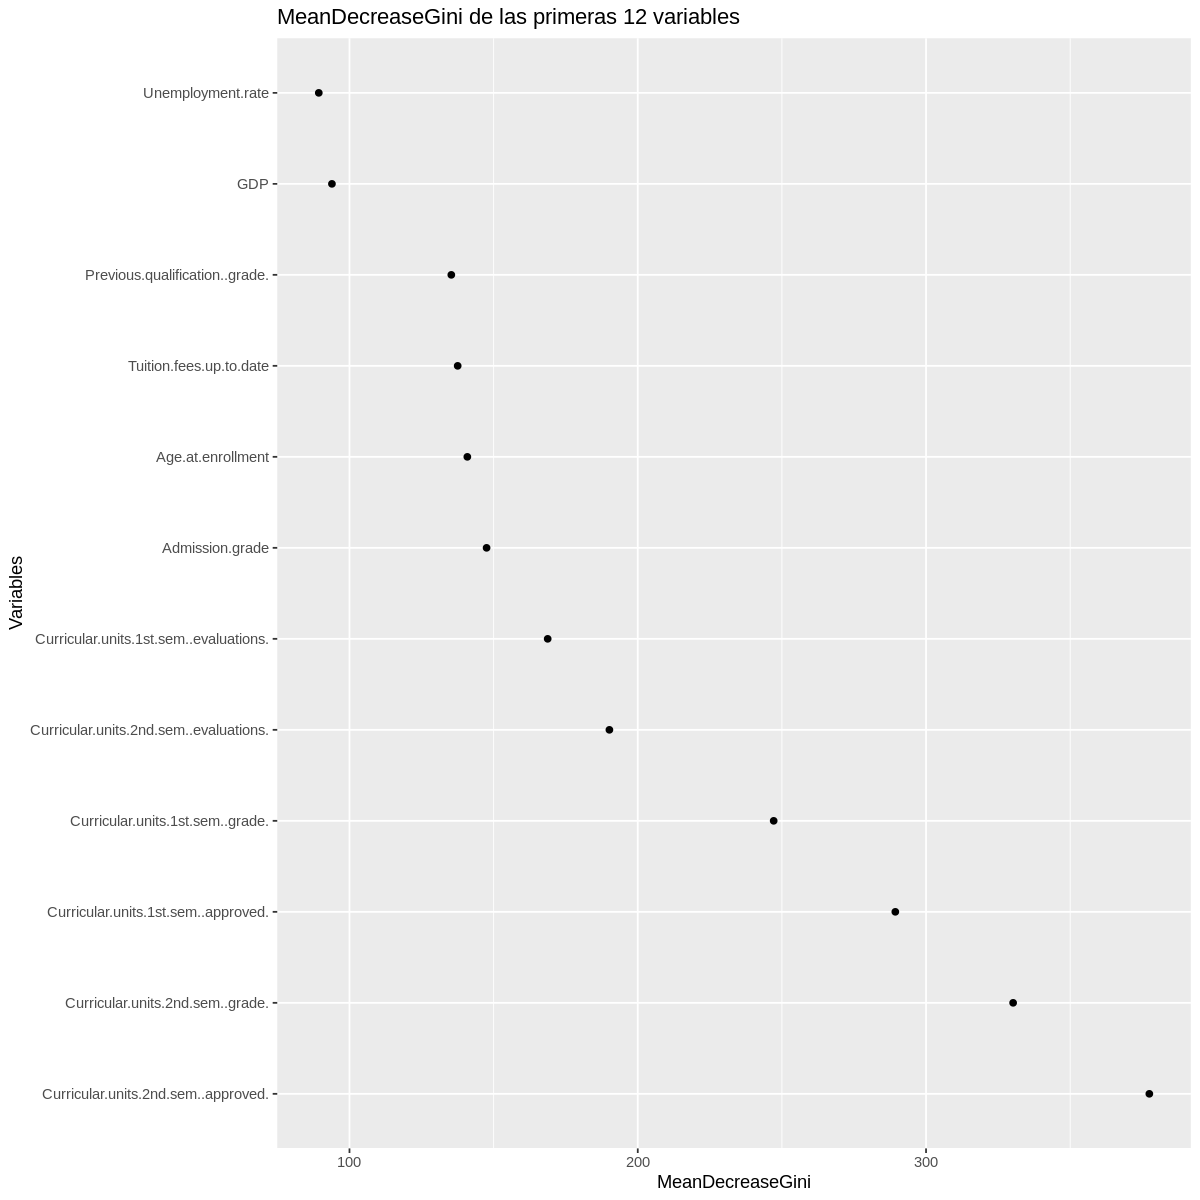

In [123]:
rf_scores_2 <- rf_scores[1:ncol(rf_data)-1,,drop=FALSE]
rf_scores_2$idx <- rownames(rf_scores_2)
rf_scores_2$idx <- factor(unique(rf_scores_2$idx),levels = unique(rf_scores_2$idx))


ggplot(rf_scores_2, aes(x = MeanDecreaseGini, y = rf_scores_2$idx)) +
  geom_point() +
  labs(x = "MeanDecreaseGini", y = "Variables", title = "MeanDecreaseGini de las primeras 12 variables") +
  theme(axis.text.y = element_text(angle = 0))

histograma de Curricular.units.2nd.sem..approved.

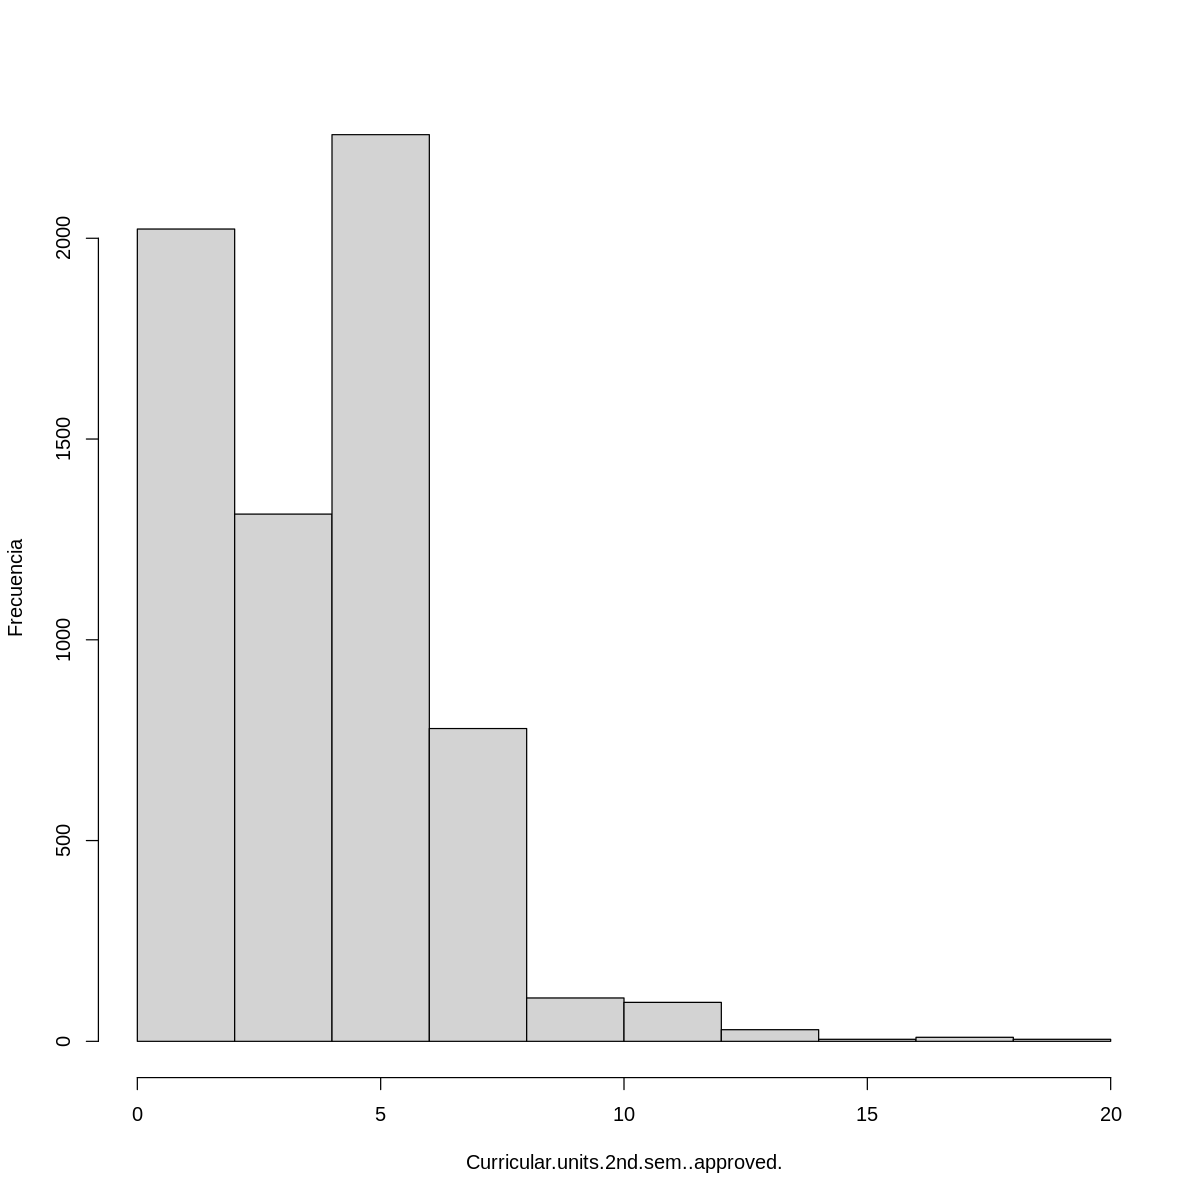

histograma de Curricular.units.2nd.sem..grade.

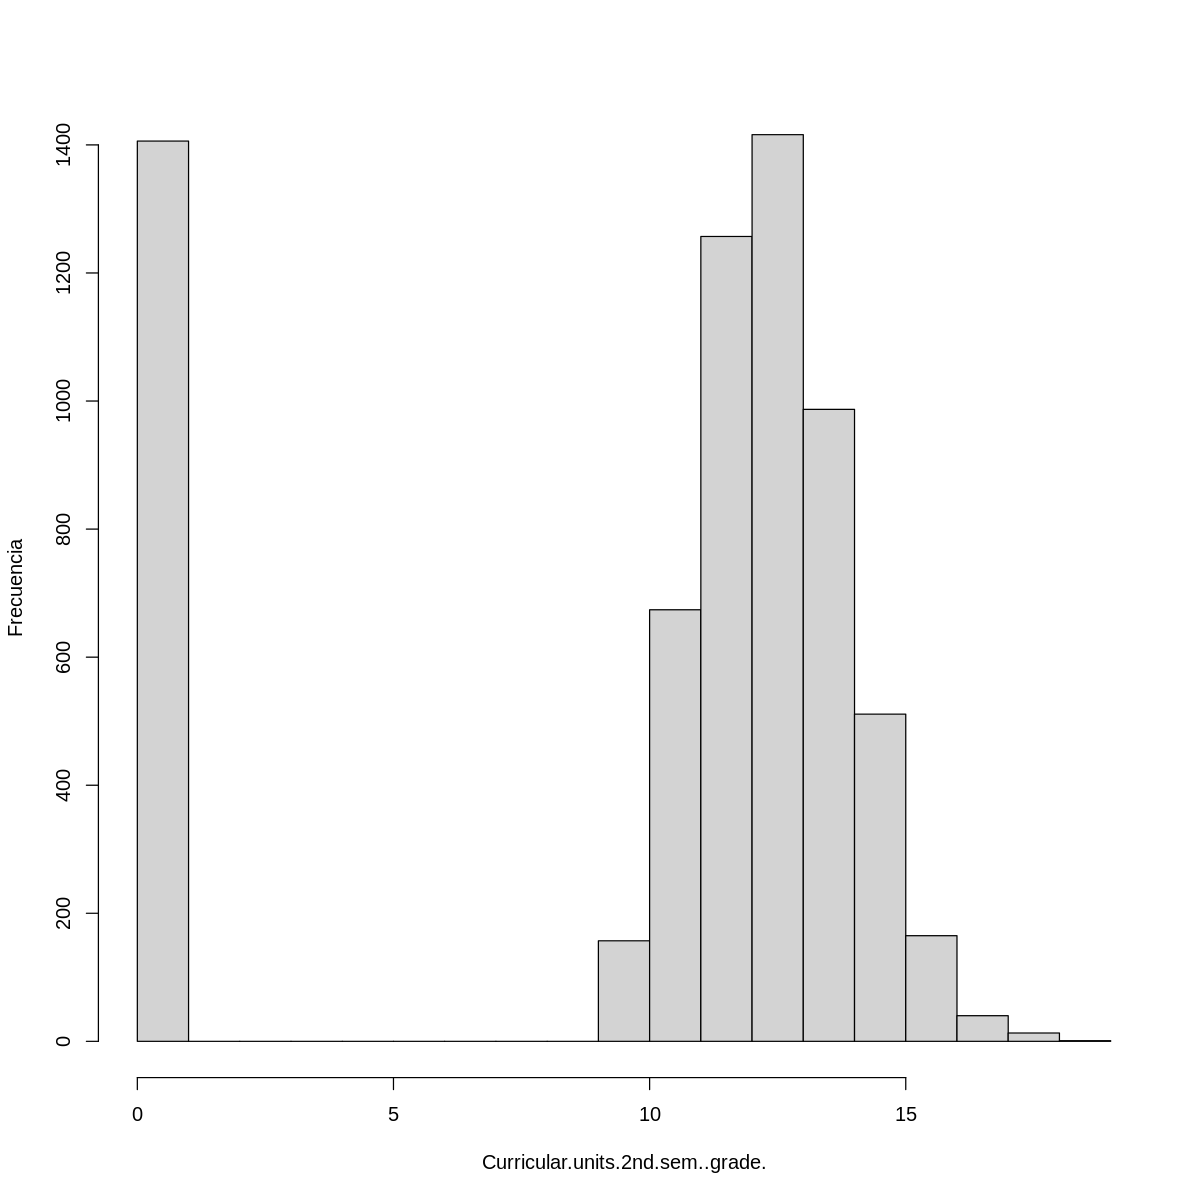

histograma de Curricular.units.1st.sem..approved.

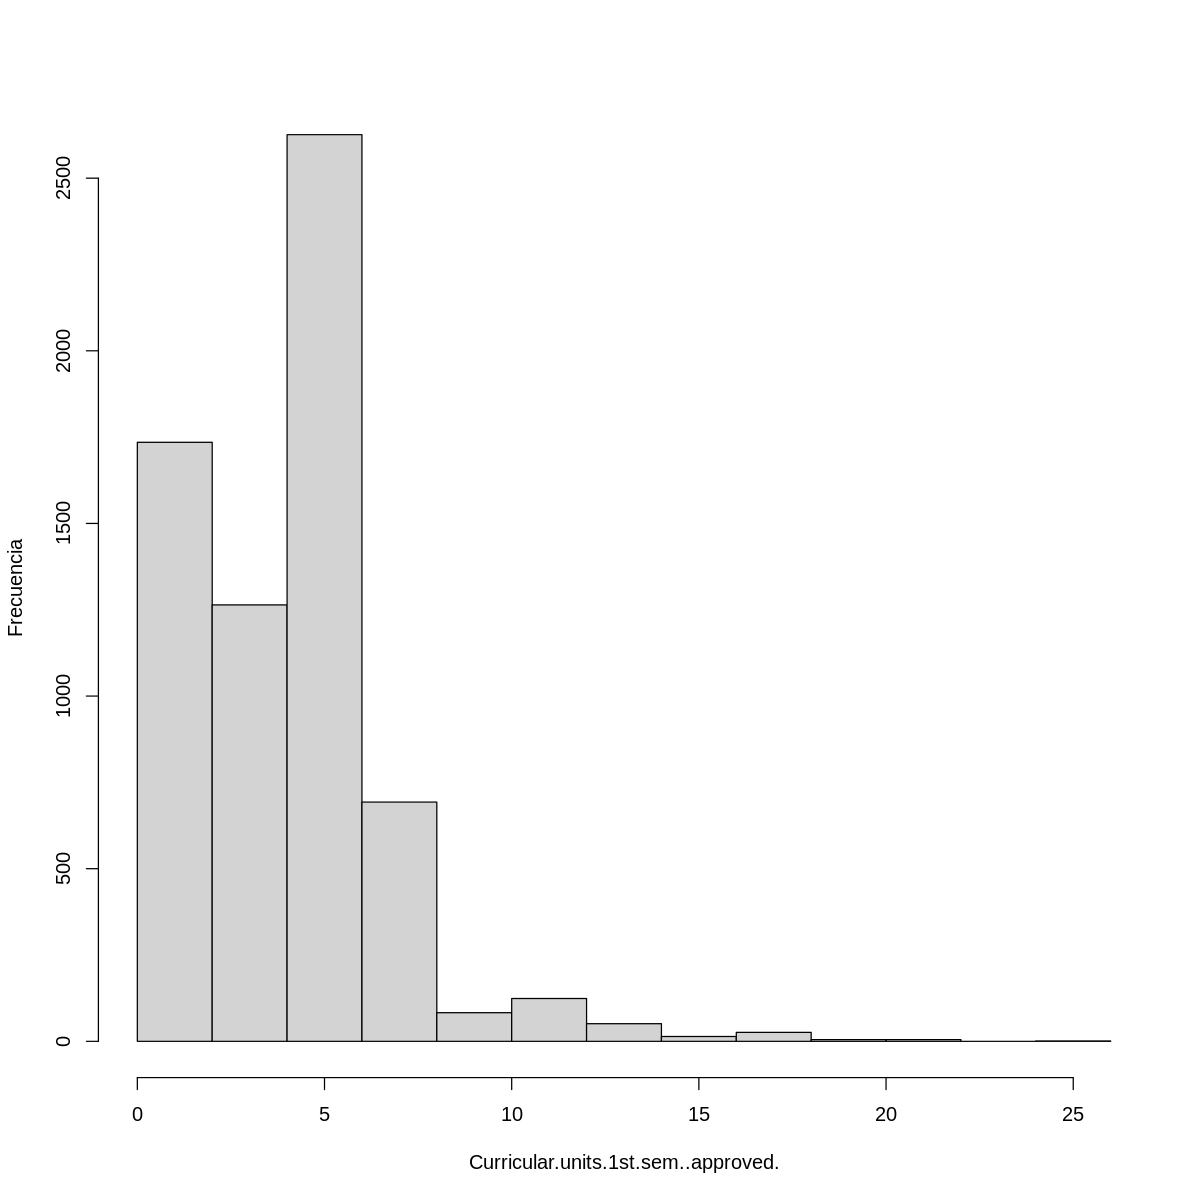

histograma de Curricular.units.1st.sem..grade.

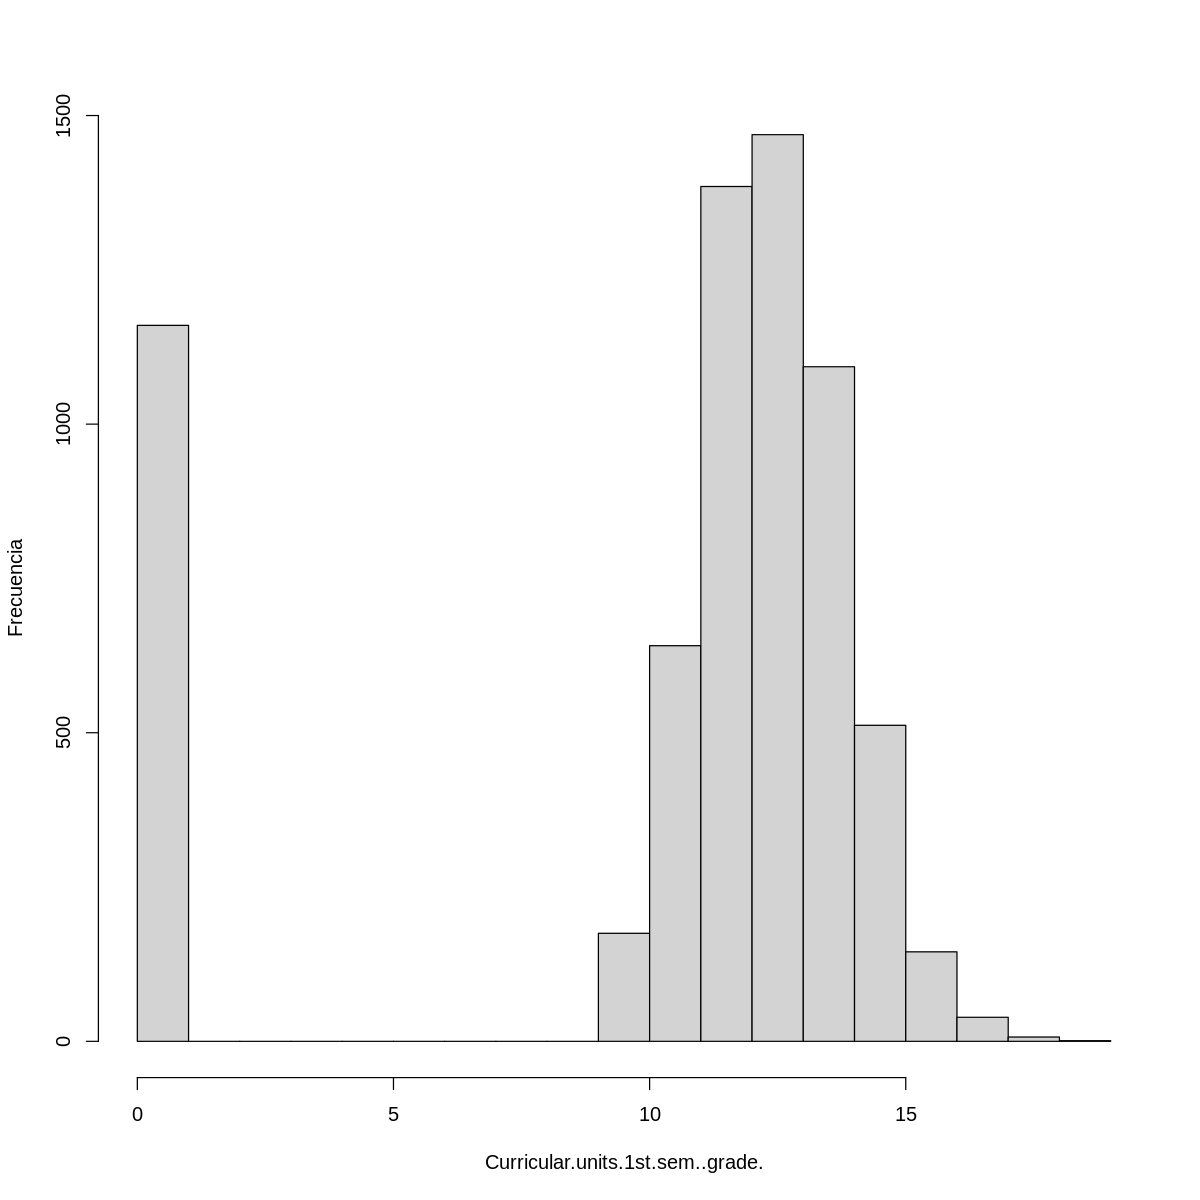

histograma de Curricular.units.2nd.sem..evaluations.

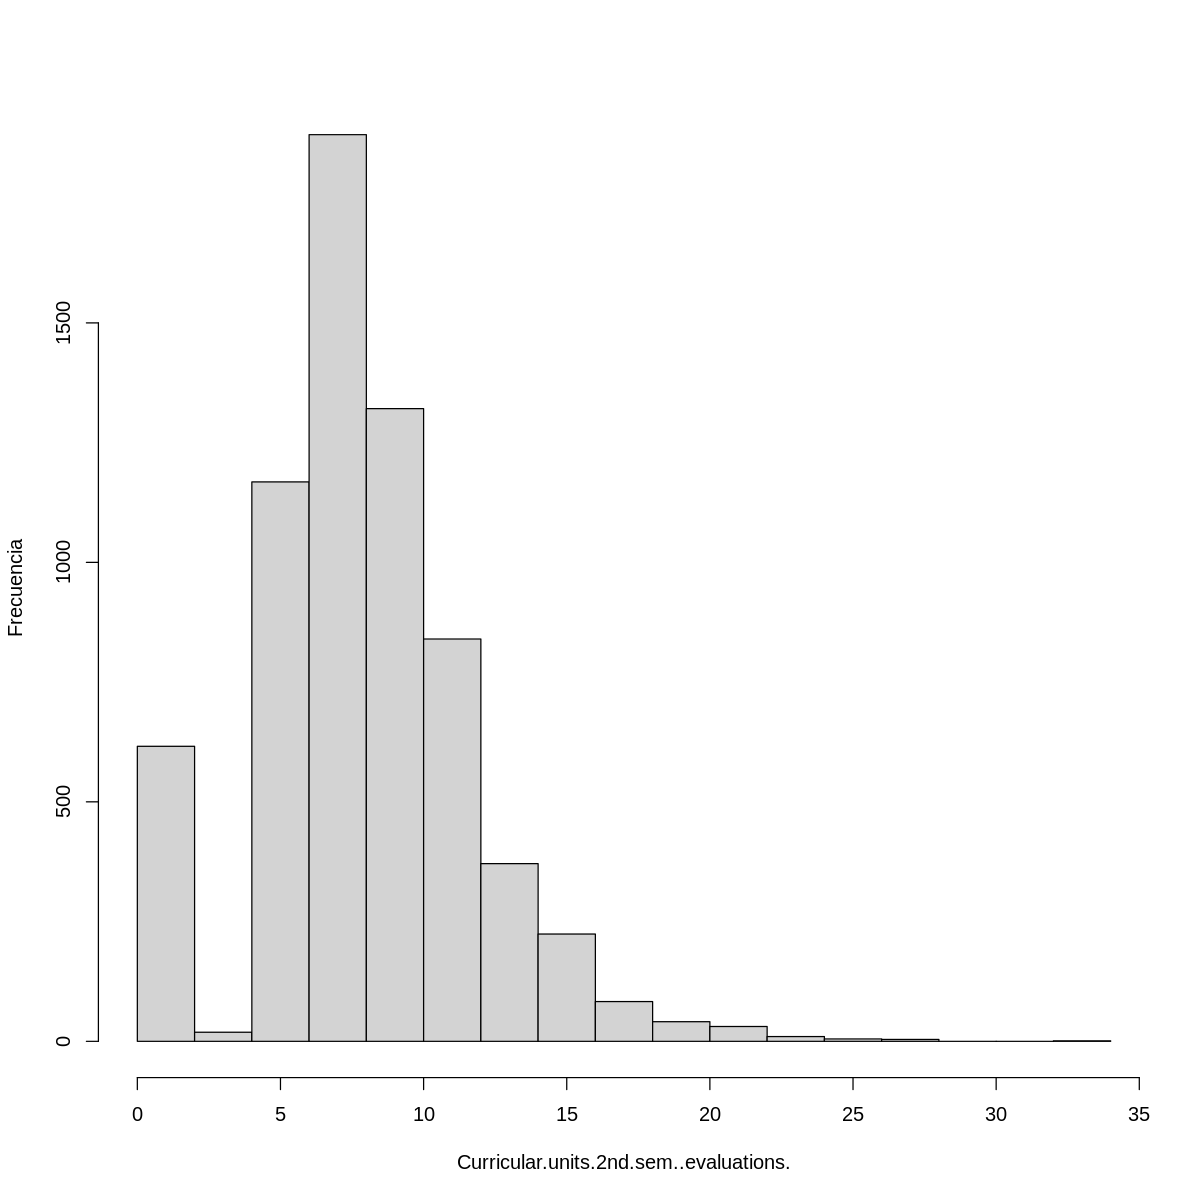

histograma de Curricular.units.1st.sem..evaluations.

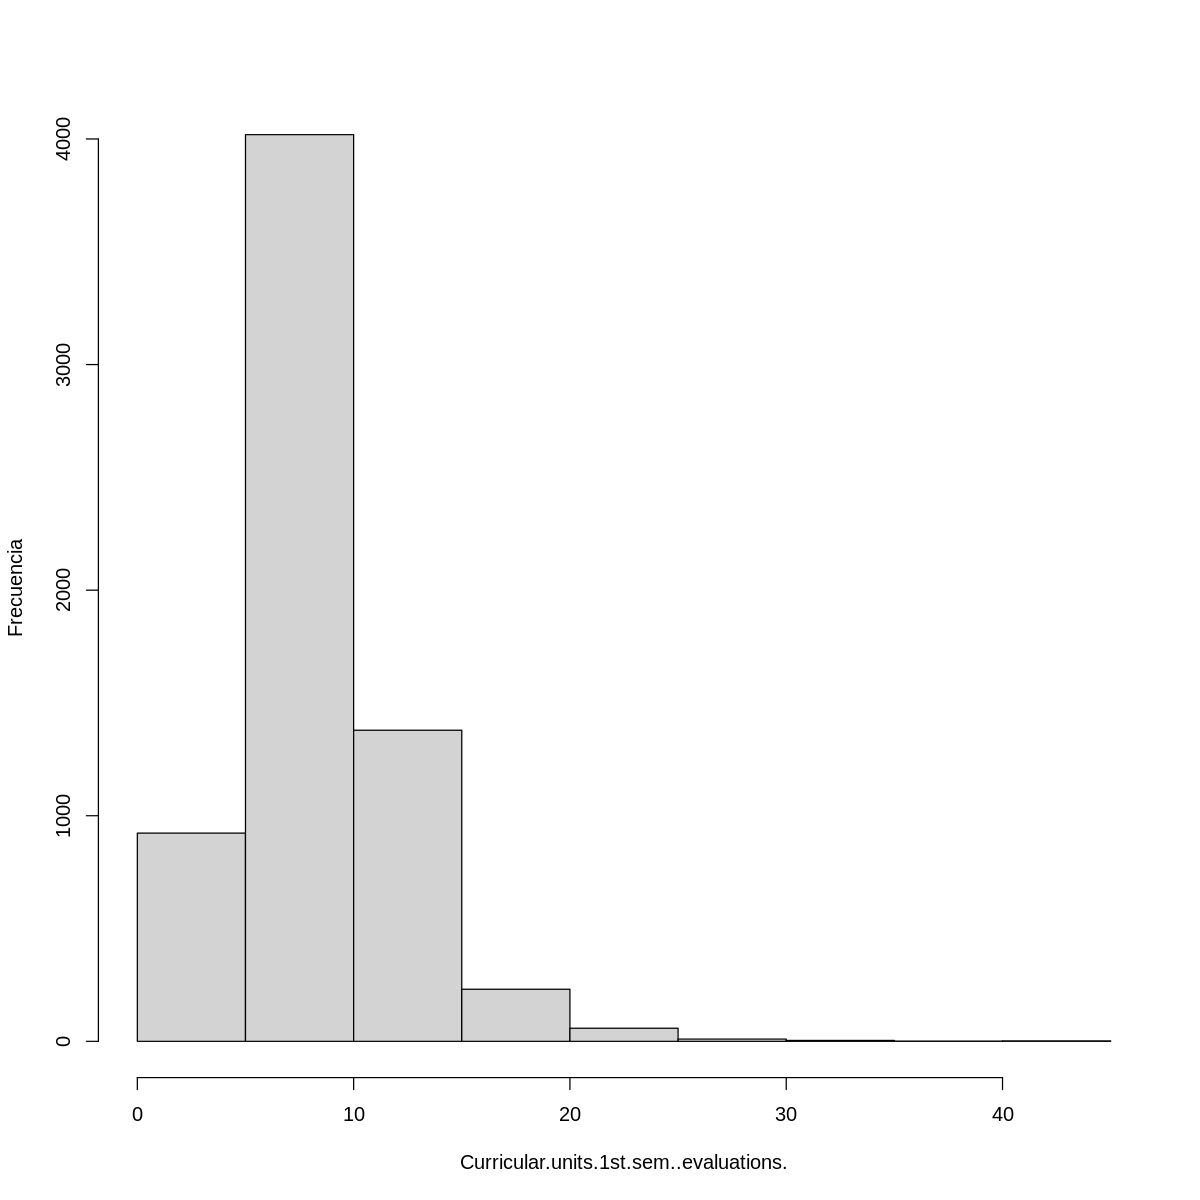

histograma de Admission.grade

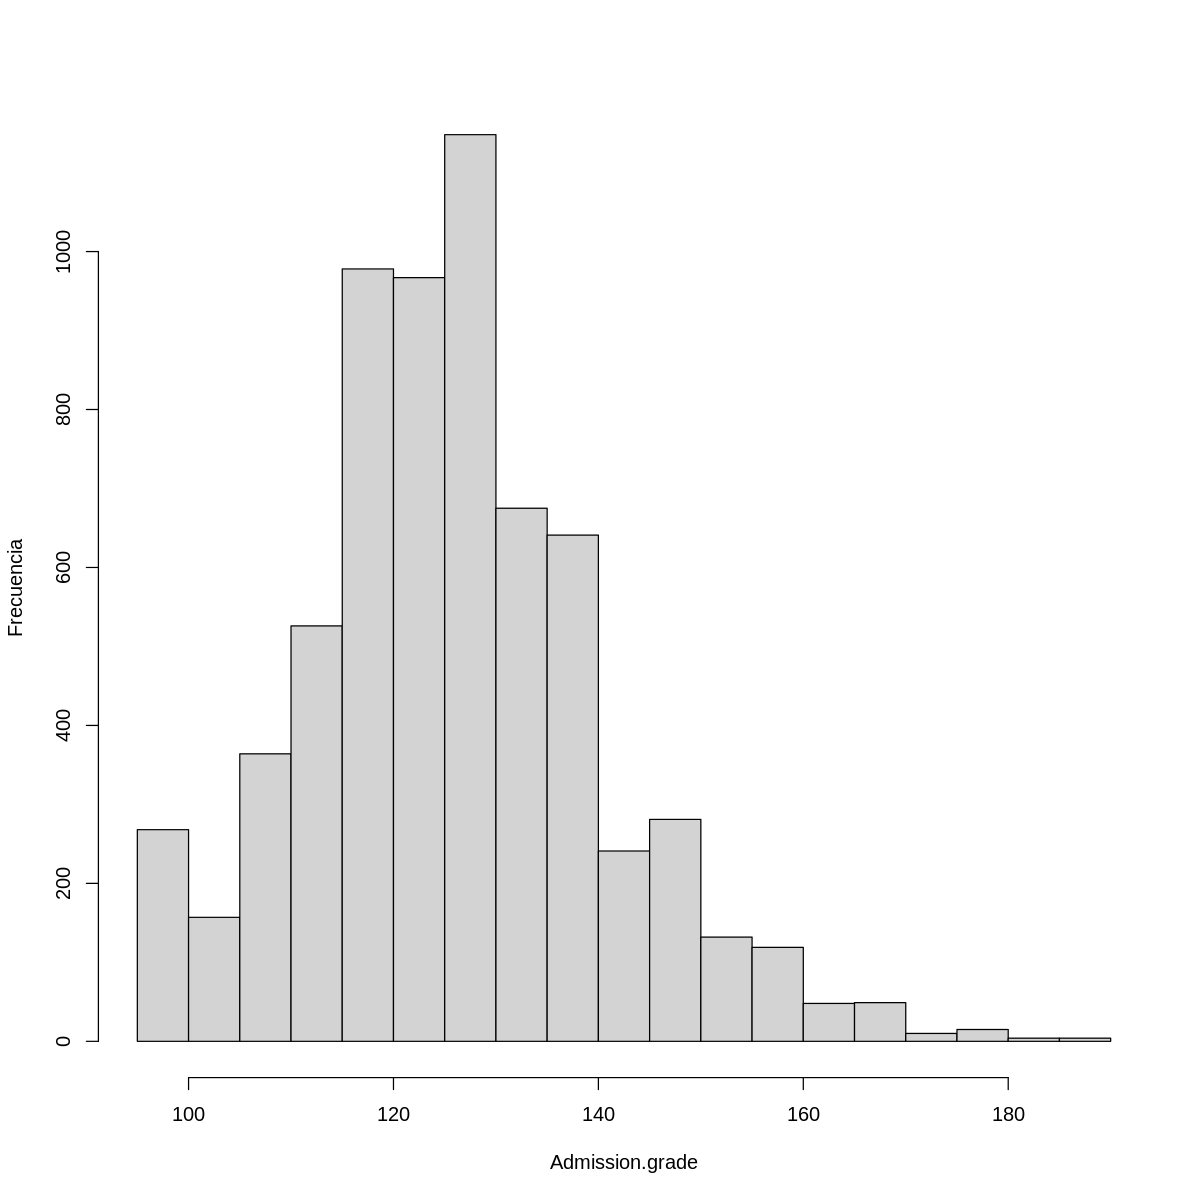

histograma de Age.at.enrollment

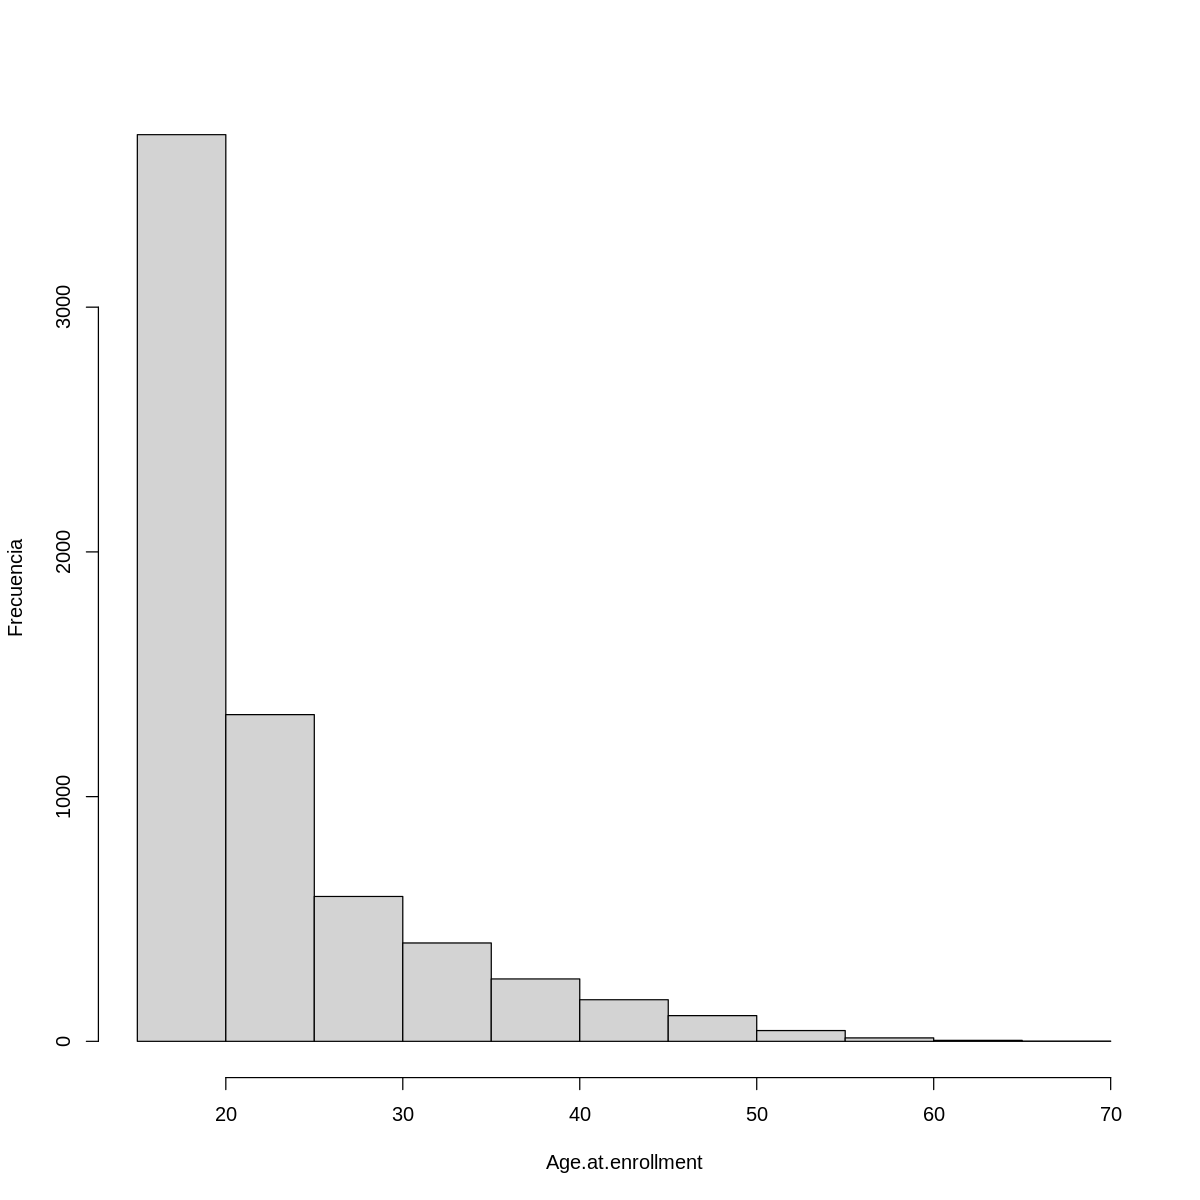

histograma de Tuition.fees.up.to.date

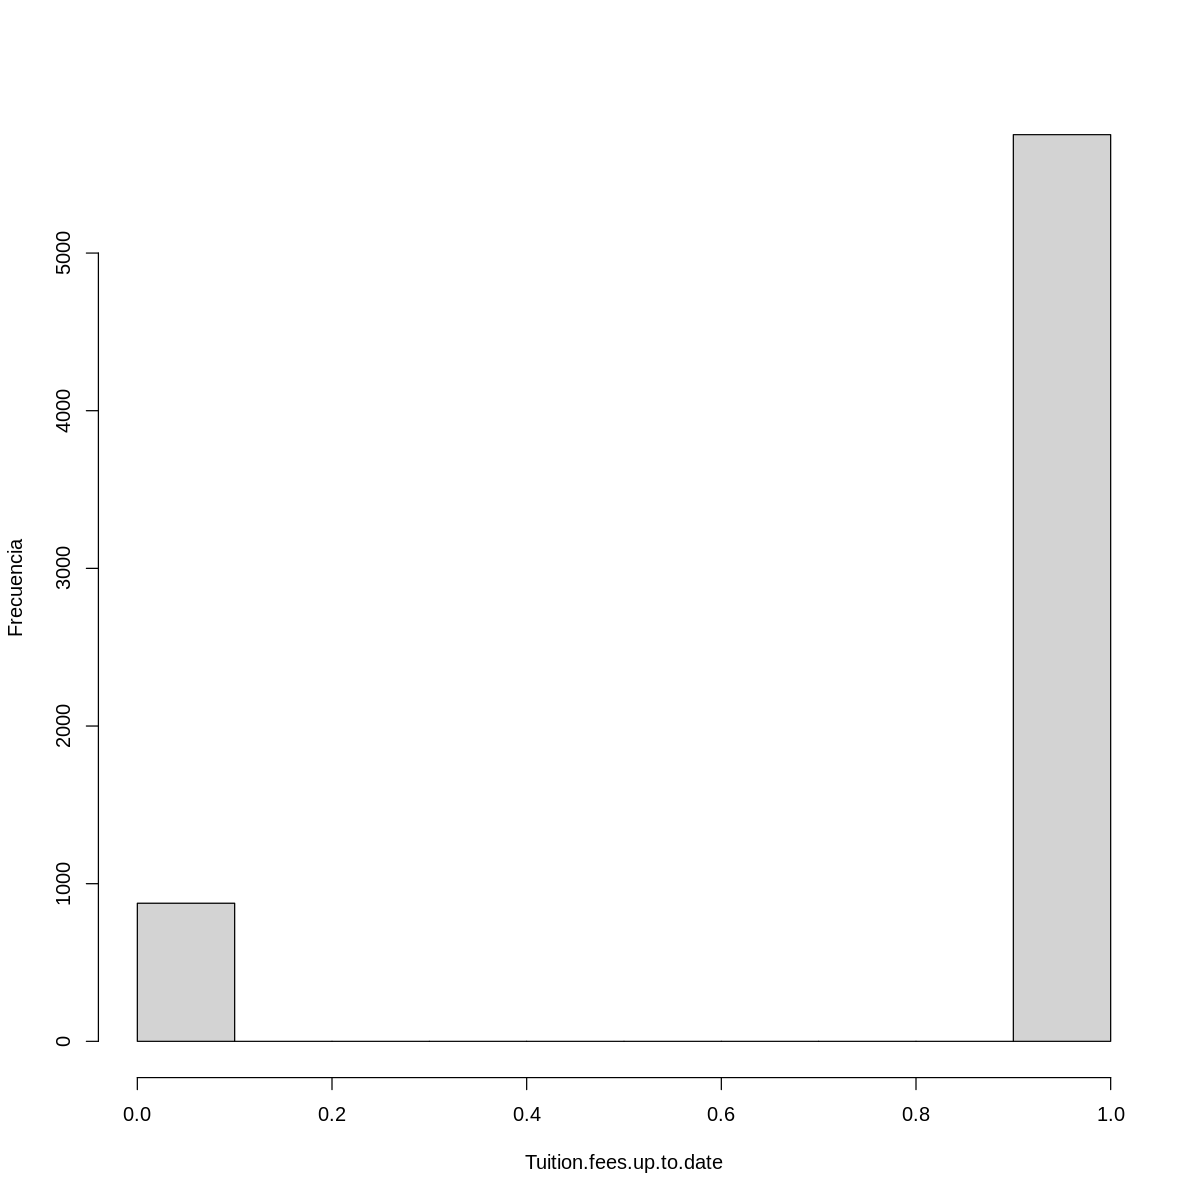

histograma de Previous.qualification..grade.

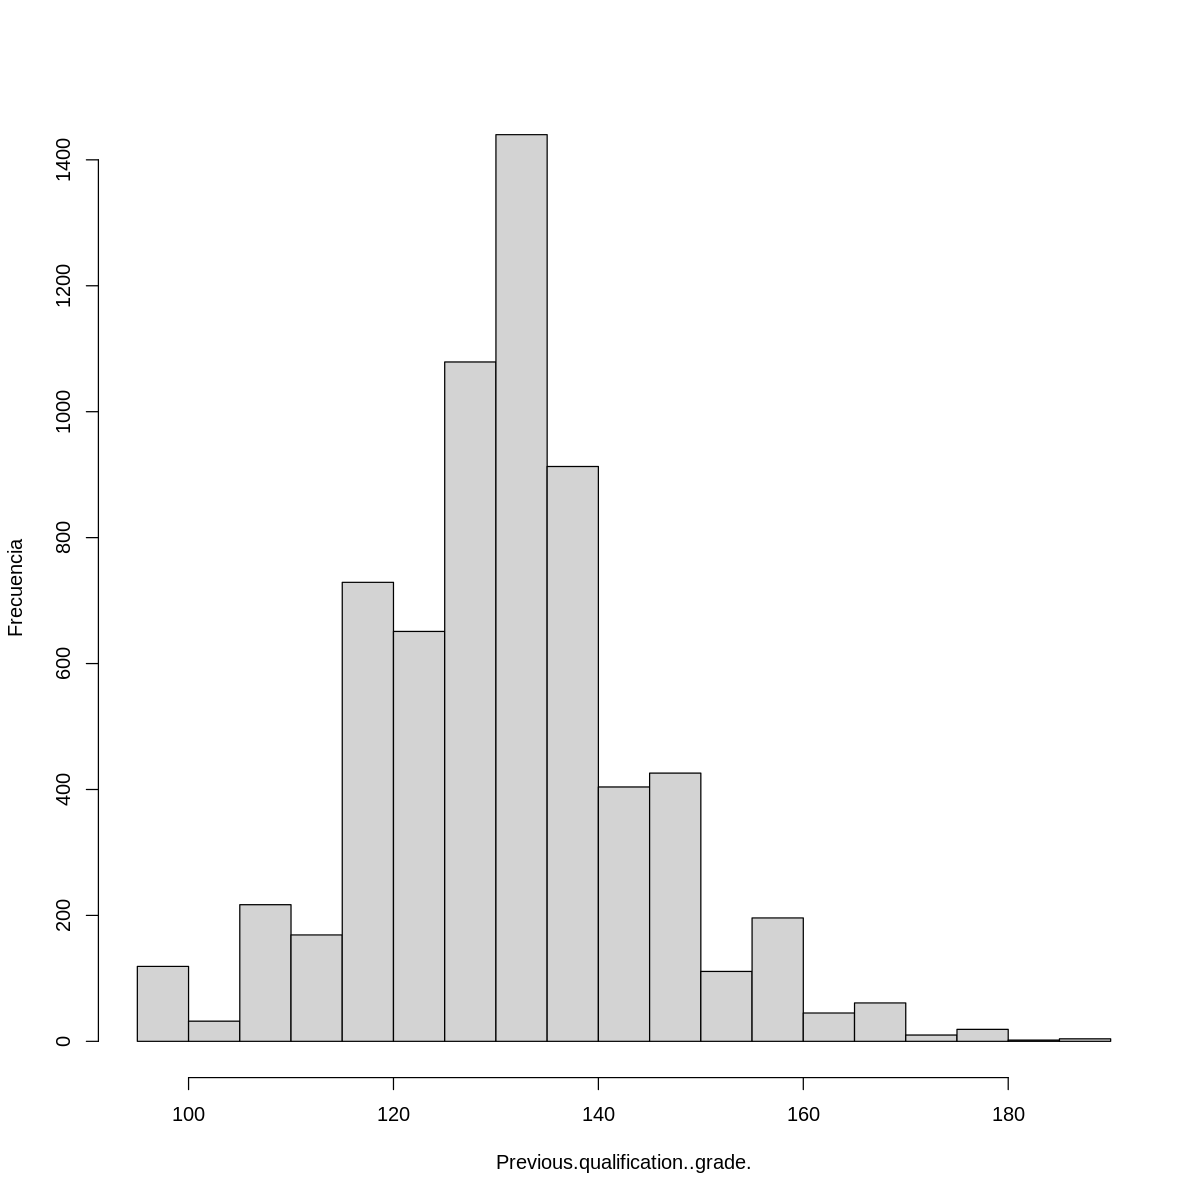

histograma de GDP

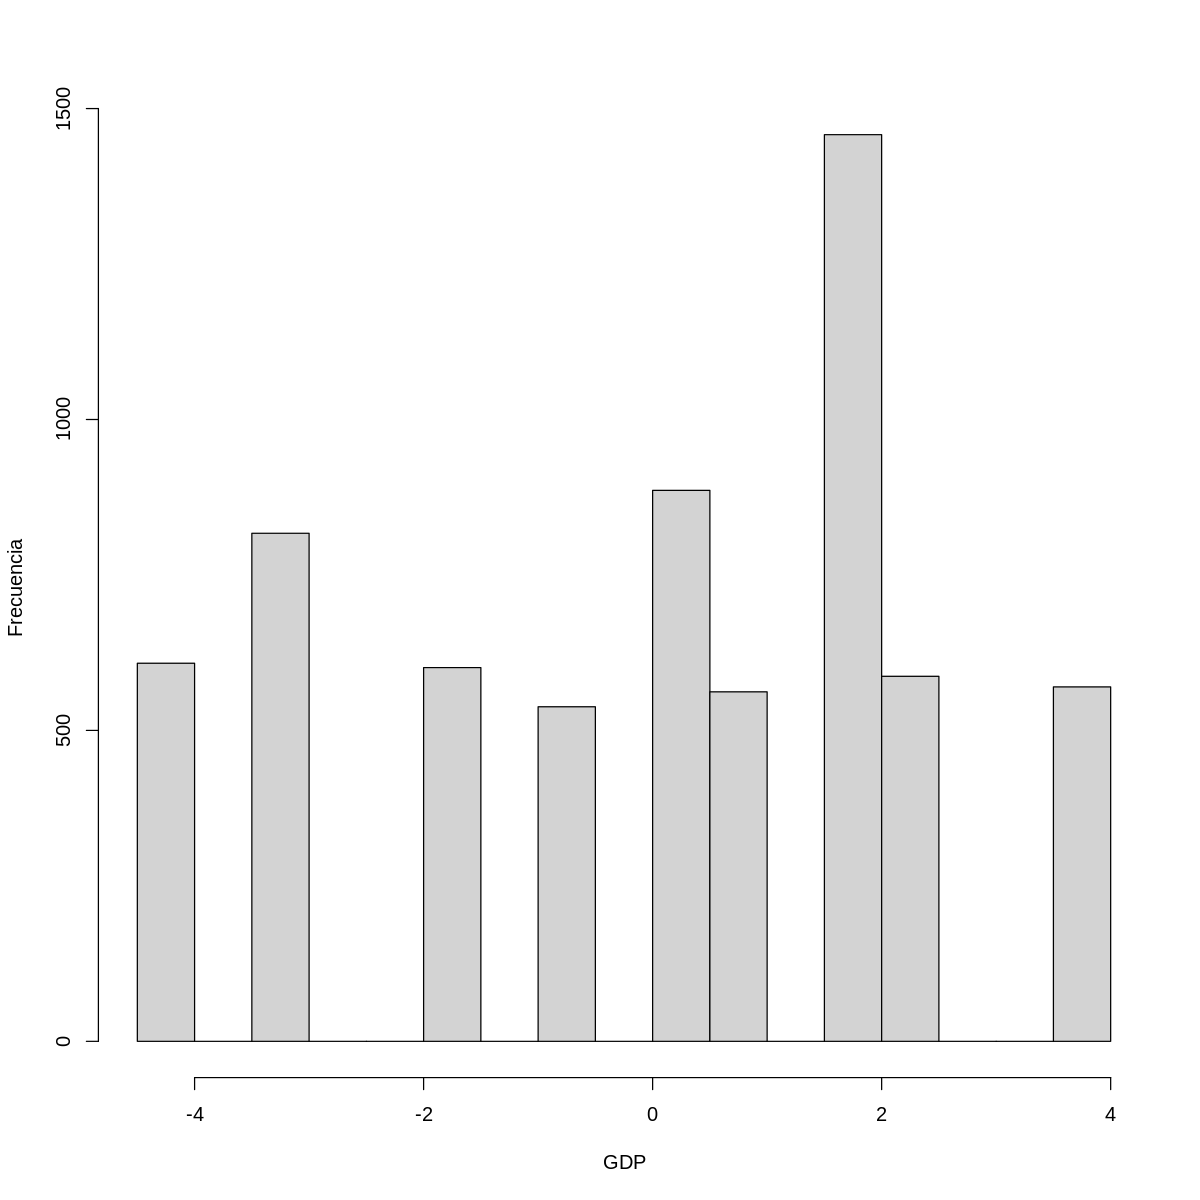

histograma de Unemployment.rate

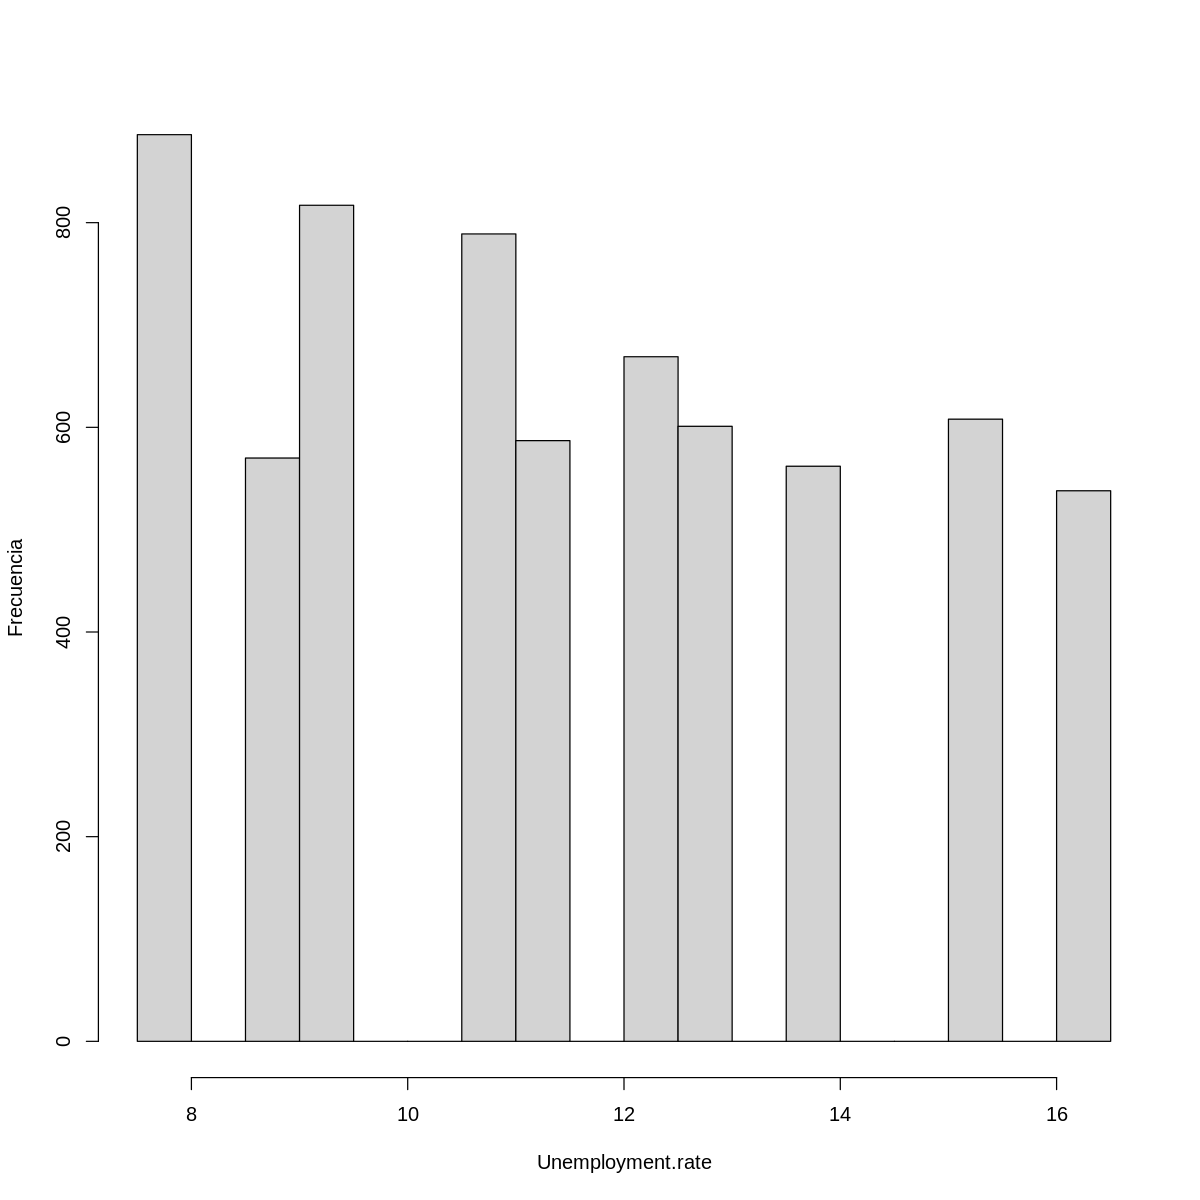

In [124]:
for(i in rf_scores_2$idx)
{
    hist(rf_data[,i],xlab = i,ylab = "Frecuencia", main= cat("histograma de",i))
}

##4.2 Boruta

In [125]:
#Boruta
boruta_result <- Boruta(Target ~ ., data = rf_data)
boruta_result<- as.vector(rownames(data.frame(boruta_result$finalDecision)))
boruta_cols <- data.frame(boruta_result)
boruta_data <- rf_data[ , c(boruta_result, "Target")]

In [126]:
boruta_cols

boruta_result
<chr>
Curricular.units.2nd.sem..approved.
Curricular.units.2nd.sem..grade.
Curricular.units.1st.sem..approved.
Curricular.units.1st.sem..grade.
Curricular.units.2nd.sem..evaluations.
Curricular.units.1st.sem..evaluations.
Admission.grade
Age.at.enrollment
Tuition.fees.up.to.date


#5 Entrenamiento y validación

##5.1 Train test split

In [127]:
#train test split
ttsplit <- function(datos, split = 0.7,target = "Target")
{
    n <- nrow(datos)
    tc <- which(colnames(datos) == target)
    idx <- sample(1:n, size = round(split * n), replace = FALSE)
    train_data <- datos[idx, ]
    test_data <- datos[-idx, ]
    return(list(train_data = train_data,
                test_data = test_data,
                x_train = train_data[,-tc],
                y_train = as.factor(train_data[,tc]),
                x_test = test_data[,-tc],
                y_test = as.factor(test_data[,tc])))
}

##5.2 Loop de entrenamiento y validación

aclaración: La función confusionMatrix de caret a veces falla y retorna NA de manera aleatoria para algunas metricas. por eso los if's

In [128]:
entre.vali <- function(data)
{
    #invariantes
    f1_rf <- c()
    f1_ada <- c()
    f1_dt <- c()

    ba_rf <- c()
    ba_ada <- c()
    ba_dt <- c()

    auc_rf <- c()
    auc_ada <- c()
    auc_dt <- c()


    for (i in seq(20))
    {
        ###############
        #Entrenamiento#
        ###############

        tts <- ttsplit(data)
        train <- tts$train_data
        test <- tts$test_data


        #random forest
        rf_model <- randomForest(Target ~ ., data = train)
        rf_pred <- predict(rf_model, newdata = tts$x_test)

        #Adaboost
        ada_model <- boosting(formula = Target ~ ., data = train, boos = TRUE, mfinal = 10)
        ada_pred <- predict(ada_model , newdata = tts$x_test)
        ada_pred <- as.factor(ada_pred$class)

        #decision tree
        dt_model <- rpart(Target ~ ., data = train, method = "class")
        dt_pred <- predict(dt_model, newdata = tts$x_test, type = "class")

        ############
        #Validación#
        ############

        #confusion matrix
        rf_con <- confusionMatrix(data = rf_pred,reference = tts$y_test)
        ada_con <- confusionMatrix(data = ada_pred,reference = tts$y_test)
        dt_con <- confusionMatrix(data = dt_pred,reference = tts$y_test)


        f1_score <- function(x)
        {
            temp <- data.frame(x$byClass)
            temp <- mean(temp$F1)
            return(temp)
        }
        if(!(is.na(f1_score(rf_con))))
        {
        f1_rf <- append(f1_rf,f1_score(rf_con))
        }

        if(!(is.na(f1_score(ada_con))))
        {
        f1_ada <- append(f1_ada,f1_score(ada_con))
        }

        if(!(is.na(f1_score(dt_con))))
        {
            f1_dt <- append(f1_dt,f1_score(dt_con))
        }

        b_acc <- function(x)
        {
            temp <- data.frame(x$byClass)
            temp <- mean(temp$Balanced.Accuracy)
            return(temp)
        }

        if(!(is.na(b_acc(dt_con))))
        {
        ba_rf <- append(ba_rf,b_acc(rf_con))
        }

        if(!(is.na(b_acc(dt_con))))
        {
        ba_ada <- append(ba_ada,b_acc(ada_con))
        }

        if(!(is.na(b_acc(dt_con))))
        {
        ba_dt <- append(ba_dt,b_acc(dt_con))
        }

        #AUC
        auc_y_test <- as.numeric(tts$y_test)

        multiclass.roc

        auc_rf <- append(auc_rf,auc(multiclass.roc(auc_y_test, as.numeric(rf_pred),quiet = TRUE)))

        auc_ada <- append(auc_ada,auc(multiclass.roc(auc_y_test, as.numeric(ada_pred),quiet = TRUE)))

        auc_dt<- append(auc_dt,auc(multiclass.roc(auc_y_test, as.numeric(dt_pred),quiet = TRUE)))




    }
    system("clear")
    comparison <- data.frame(f1 = c(round(mean(f1_rf),2), round(mean(f1_ada),2), round(mean(f1_dt),2)),
                        auc = c(round(mean(auc_rf),2), round(mean(auc_ada),2), round(mean(auc_dt),2)),
                        ba = c(round(mean(ba_rf),2),round(mean(ba_ada),2),round(mean(ba_dt),2)),
                        row.names = c("random forest", "adaboost", "decision tree"))
    return(comparison)
}

#6 Comparación de resultados

In [129]:
comparison <- entre.vali(boruta_data)
comparison

,f1,auc,ba
,<dbl>,<dbl>,<dbl>
random forest,0.88,0.91,0.91
adaboost,0.69,0.81,0.77
decision tree,0.68,0.80,0.76


#<font size="1000"><center>**PARTE 2**</center></font>

In [130]:
#descargar datos
origin <- "https://archive.ics.uci.edu/static/public/697/predict+students+dropout+and+academic+success.zip"

download.file(origin, destfile = "origin2.zip", mode = "wb")

file_list <- unzip("origin2.zip", list = TRUE)

data2 <- read.csv(unz("origin2.zip","data.csv"),sep = ";")

In [131]:
#codificar target
if(all(unique(data2$Target) != c("0","1","2")) || all(levels(data2$Target) != c("0","1","2")) )
{
    data2$Target <- ifelse(data2$Target == "Dropout", 0,
                        ifelse(data2$Target == "Enrolled", 1,
                        ifelse(data2$Target == "Graduate", 2, NA)))

    data2$Target <- as.factor(data2$Target)
}

if(length(unique(data2$Target)) == 3)
{
    print("Target se codifico sin NA")
}else
{
    if((length(unique(data2$Target)) == 4))
    {
        print("Target se codifico con NA")
    }else
    {
        print("Target no se codifico correctamente")
    }
}



[1] "Target se codifico sin NA"


In [132]:
data2 <- data.frame(data2)

#7 Comparacion 2

##7.1 XGBoost

In [133]:
xgbdata <- c("Curricular.units.2nd.sem..approved.",
            "Tuition.fees.up.to.date",
            "Curricular.units.1st.sem..approved.",
            "Course",
            "Curricular.units.2nd.sem..enrolled.",
            "Curricular.units.2nd.sem..grade.",
            "Mother.s.occupation",
            "Debtor",
            "Curricular.units.1st.sem..enrolled.",
            "Scholarship.holder",
            "Target")

In [134]:
xgbdata <- data2[ , xgbdata]

In [135]:
anyNA(xgbdata)

[1] FALSE

In [136]:
comp_xgb <- entre.vali(xgbdata)
comp_xgb

,f1,auc,ba
,<dbl>,<dbl>,<dbl>
random forest,0.69,0.81,0.78
adaboost,0.64,0.78,0.75
decision tree,0.63,0.77,0.73


##7.2 Random forest

In [137]:
rfdata <- c("Curricular.units.2nd.sem..approved.",
            "Tuition.fees.up.to.date",
            "Curricular.units.1st.sem..approved.",
            "Course",
            "Curricular.units.2nd.sem..evaluations.",
            "Curricular.units.2nd.sem..grade.",
            "Inflation.rate",
            "Curricular.units.1st.sem..evaluations.",
            "Curricular.units.1st.sem..enrolled.",
            "Scholarship.holder",
            "Target")

In [138]:
rfdata <- data2[ , rfdata]

In [139]:
comp_rf <- entre.vali(rfdata)
comp_rf

,f1,auc,ba
,<dbl>,<dbl>,<dbl>
random forest,0.68,0.80,0.77
adaboost,0.64,0.78,0.75
decision tree,0.64,0.77,0.74


##7.3 Catboost

In [140]:
catdata <- c("Curricular.units.2nd.sem..approved.",
            "Tuition.fees.up.to.date",
            "Curricular.units.1st.sem..approved.",
            "Course",
            "Curricular.units.2nd.sem..enrolled.",
            "Curricular.units.2nd.sem..grade.",
            "Curricular.units.2nd.sem..evaluations.",
            "Debtor",
            "Curricular.units.1st.sem..enrolled.",
            "Curricular.units.1st.sem..evaluations.",
            "Target")

In [141]:
catdata <- data2[ , catdata]

In [142]:
comp_cat <- entre.vali(catdata)
comp_cat

,f1,auc,ba
,<dbl>,<dbl>,<dbl>
random forest,0.68,0.80,0.77
adaboost,0.65,0.78,0.75
decision tree,0.65,0.77,0.73


##7.4 LightGBM

In [143]:
lgbmdata <- c("Curricular.units.2nd.sem..approved.",
            "Tuition.fees.up.to.date",
            "Curricular.units.1st.sem..approved.",
            "Course",
            "Curricular.units.2nd.sem..enrolled.",
            "Curricular.units.2nd.sem..grade.",
            "Curricular.units.2nd.sem..evaluations.",
            "Mother.s.occupation",
            "Unemployment.rate",
            "Curricular.units.1st.sem..evaluations.",
            "Target")

In [144]:
lgbmdata <- data2[ , lgbmdata]

In [145]:
comp_lgbm <- entre.vali(lgbmdata)
comp_lgbm

,f1,auc,ba
,<dbl>,<dbl>,<dbl>
random forest,0.68,0.80,0.77
adaboost,0.64,0.78,0.74
decision tree,0.64,0.77,0.73


# RESULTADOS

In [146]:
comp_total <- rbind(comparison,comp_xgb,comp_rf,comp_cat,comp_lgbm)
comp_total$Feature_Selection <- rep(c("RF+Boruta","XGBoost", "Random Forest", "CatBoost", "LightGBM"), each = 3)
comp_total$Model <- rownames(comp_total)
comp_total <- comp_total[c("Feature_Selection","Model","f1","auc","ba")]
comp_total

,Feature_Selection,Model,f1,auc,ba
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
random forest,RF+Boruta,random forest,0.88,0.91,0.91
adaboost,RF+Boruta,adaboost,0.69,0.81,0.77
decision tree,RF+Boruta,decision tree,0.68,0.80,0.76
random forest1,XGBoost,random forest1,0.69,0.81,0.78
adaboost1,XGBoost,adaboost1,0.64,0.78,0.75
decision tree1,XGBoost,decision tree1,0.63,0.77,0.73
random forest2,Random Forest,random forest2,0.68,0.80,0.77
adaboost2,Random Forest,adaboost2,0.64,0.78,0.75
decision tree2,Random Forest,decision tree2,0.64,0.77,0.74
